https://github.com/ycheng30/Expedia-Hotel-Recommendation-Kaggle/blob/master/Expedia_partial_data.ipynb

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Hotel%20recommendation.ipynb

In [0]:
import pandas as pd
import numpy as np
import pickle
import time
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import zipfile
import io
from google.colab import files

In [0]:
uploaded = files.upload()

Saving train_round5.csv.zip to train_round5.csv.zip


In [0]:
! unzip train_round5.csv.zip

Archive:  train_round5.csv.zip
  inflating: train_round5.csv        


In [0]:
train = pd.read_csv('train_round5.csv')

In [0]:
train.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,check_in,check_out,adult_count,child_count,room_count,destination_id,destination_type_id,is_booking,similar_events,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay_duration,plan_time,solo_travel,short_trip,weekend_trip,booking_rate,price_compare,biz_trip
0,0,2014-07-16 09:42:23,2,3,66,189,10067,2014.665587,501,0,0,2,2014-08-01 00:00:00,2014-08-02 00:00:00,2,0,1,8267,1,0,2,2,50,675,41,1.0,15.0,0,1,1,0.0,1,0
1,1,2014-07-16 09:45:48,2,3,66,189,10067,2014.665587,501,0,1,2,2014-08-01 00:00:00,2014-08-02 00:00:00,2,0,1,8267,1,0,1,2,50,675,41,1.0,15.0,0,1,1,0.0,1,0
2,2,2014-07-16 09:55:24,2,3,66,189,10067,2014.665587,501,0,0,2,2014-08-01 00:00:00,2014-08-02 00:00:00,2,0,1,8267,1,0,1,2,50,675,70,1.0,15.0,0,1,1,0.0,1,0
3,3,2014-07-16 10:00:06,2,3,66,189,10067,2014.665587,501,0,0,2,2014-08-01 00:00:00,2014-08-02 00:00:00,2,0,1,8267,1,0,1,2,50,675,98,1.0,15.0,0,1,1,0.0,1,0
4,4,2014-11-22 20:55:38,30,4,195,991,47725,2014.665587,1048,1,0,9,2015-06-26 00:00:00,2015-06-28 00:00:00,2,0,1,8803,1,0,1,3,151,1197,5,2.0,215.0,0,1,1,0.0,1,0


In [0]:
# remove datetime columns for model
train.drop(columns=['Unnamed: 0','date_time', 'check_in','check_out',], inplace=True)

In [0]:
#drop according to feature importance 
train.drop(columns=['is_booking','short_trip','room_count','solo_travel','is_mobile','weekend_trip','posa_continent','similar_events',\
                    'is_package','adult_count','child_count','channel','user_location_country','price_compare','biz_trip'], inplace=True)

In [0]:
train['hotel_cluster'].replace([91, 41, 48, 64, 5, 65, 98, 59, 70, 42], \
                               ['ninety-one','forty-one','forty-eight','sixty-four', 'five',\
                               'sixty-five','ninety-eight','fifty-nine','seventy','forty-two'], inplace=True)
train['hotel_cluster'].value_counts()

ninety-one      55752
forty-one       41797
forty-eight     39948
sixty-four      39625
five            32914
sixty-five      32783
ninety-eight    32017
fifty-nine      30602
seventy         30269
forty-two       29740
Name: hotel_cluster, dtype: int64

In [0]:
train.shape

(365447, 14)

### Decision Tree Classifier

In [0]:
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

In [0]:
X = train.drop(['hotel_cluster'], axis=1)
y = train['hotel_cluster']

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# y = LabelEncoder().fit_transform(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [0]:
tree = DecisionTreeClassifier(max_depth=12, criterion='entropy', max_features=12)

tree = tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)

In [0]:
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("The score is")
print("Training: {:6.2f}%".format(100*tree.score(X_train, y_train)))
print("Validate: {:6.2f}%".format(100*tree.score(X_val, y_val)))
print("Testing: {:6.2f}%".format(100*tree.score(X_test, y_test)))

Accuracy: 0.46273087973731014
The score is
Training:  49.21%
Validate:  46.27%
Testing:  46.20%


In [0]:
tree_pred = tree.predict(X_val)
print('Tree Results:')
print(confusion_matrix(y_val, tree_pred))
print(classification_report(y_val, tree_pred))

Tree Results:
[[2278  480  173   59  178  217 1796    7   17  801]
 [ 535 2239  240  522  105  254 1049  141  195 1312]
 [ 253  310 1145  515  285  190 5008  106   22  189]
 [ 122  365  236 2030   57  784 2643 1754  108  409]
 [ 305  187  476  126  562   81 3965    5   29  184]
 [ 235  110   55  579   24 2378  958 1615   44  318]
 [ 296  159  649  463  366  260 8514  266    9   77]
 [  22  109   79  985    8 1140  984 2543    5  197]
 [   2   14    4   10    2    0   10    0 6468   37]
 [ 441  838   50  189   19  469   88   36  253 5664]]
              precision    recall  f1-score   support

  fifty-nine       0.51      0.38      0.43      6006
        five       0.47      0.34      0.39      6592
 forty-eight       0.37      0.14      0.21      8023
   forty-one       0.37      0.24      0.29      8508
   forty-two       0.35      0.09      0.15      5920
ninety-eight       0.41      0.38      0.39      6316
  ninety-one       0.34      0.77      0.47     11059
     seventy       0.3

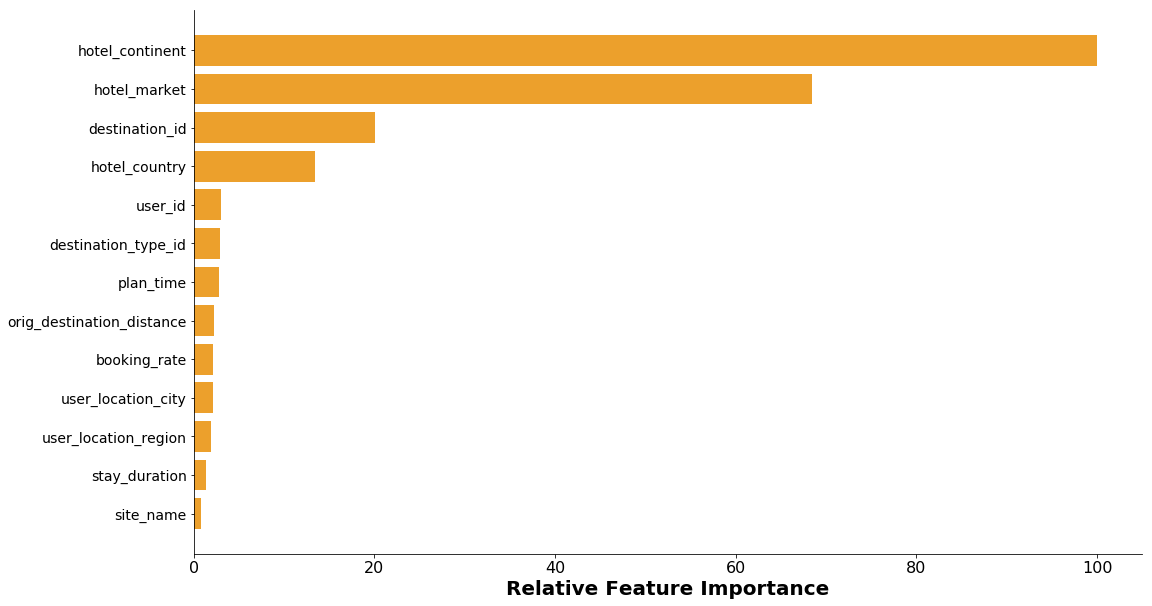

In [0]:
# feat_imp = pd.DataFrame({'importance':tree.feature_importances_})    
# feat_imp['feature'] = X_train.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# title = 'Feature Importance'
# figsize = (10,10)
# # featax = featfig.add_subplot(1, 1, 1)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp.plot.barh(title=title, figsize=figsize)
# plt.xlabel('Feature Importance Score')

# plt.show()

feature_importance = abs(tree.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(1,figsize=(17,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#eca02c')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=14)

featax.set_xlabel('Relative Feature Importance', fontsize=20, weight='bold')
featax.tick_params(axis="x", labelsize=16)


featax.spines['right'].set_visible(False)
featax.spines['top'].set_visible(False)
featax.spines['bottom'].set_visible(True)
featax.spines['left'].set_visible(True)

featax.patch.set_visible(False)

plt.savefig('feature_importance.jpg', transparent=True);
# plt.show()


In [0]:
files.download('all_feature_importance.jpg')

FileNotFoundError: ignored

In [0]:
est = DecisionTreeClassifier()

rf_p_dist={
           'criterion':['gini','entropy'],
           'max_depth':[3,6,9,12],
           'max_features':[3,6,9,12],
          }

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [0]:
hypertuning_rscv(est, rf_p_dist, 40, X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


({'criterion': 'entropy', 'max_depth': 12, 'max_features': 12},
 0.4421407208158775)

### XGBoost

In [0]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [0]:
X = train.drop(['hotel_cluster'], axis=1)
y = train['hotel_cluster']

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [0]:
model = XGBClassifier(max_depth=12)

model = model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [0]:
print("Validate accuracy: %.2f" % (accuracy_score(y_val, y_pred_val) * 100))
print("Test accuracy: %.2f" % (accuracy_score(y_test, y_pred_test) * 100))

Validate accuracy: 56.16
Test accuracy: 56.33


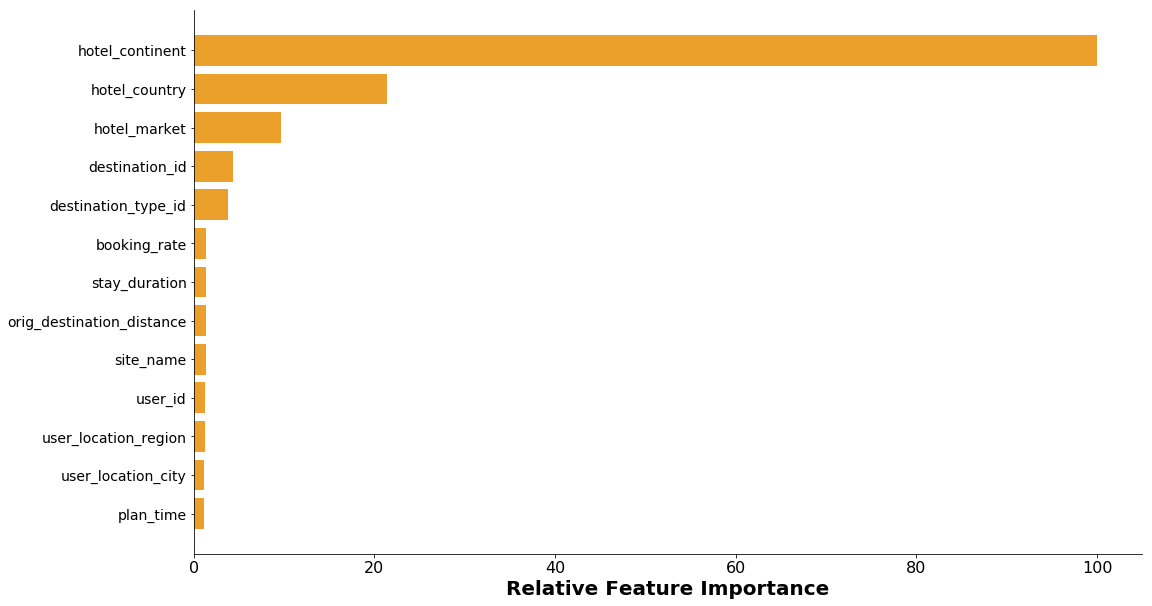

In [0]:
feature_importance = abs(model.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(1,figsize=(17,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#eca02c')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=14)

featax.set_xlabel('Relative Feature Importance', fontsize=20, weight='bold')
featax.tick_params(axis="x", labelsize=16)


featax.spines['right'].set_visible(False)
featax.spines['top'].set_visible(False)
featax.spines['bottom'].set_visible(True)
featax.spines['left'].set_visible(True)

featax.patch.set_visible(False)

plt.savefig('feature_importance.jpg', transparent=True);
# plt.show()

### GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
est = xgb.XGBClassifier()

rf_p_dist = {
     "eta"    : [0.01, 0.1, 0.3] ,
     "max_depth"        : [ 6, 9, 12],
     "min_child_weight" : [ 3, 5, 7 ],
     "gamma"            : [ 0.1, 0.3, 0.4 ],
     }

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [0]:
hypertuning_rscv(est, rf_p_dist, 1, X, y)

### K-fold evaluation

In [0]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
X = train.drop(['hotel_cluster'], axis=1)
y = train['hotel_cluster']

In [0]:
# CV model
model = XGBClassifier(max_depth=12)
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.46795731 0.4705158  0.46681443 0.46996128 0.46602088]
Accuracy: 46.83% (0.17%)


In [0]:
results = [0.46795731, 0.4705158,  0.46681443, 0.46996128, 0.46602088]
# Accuracy: 46.83% (0.17%)

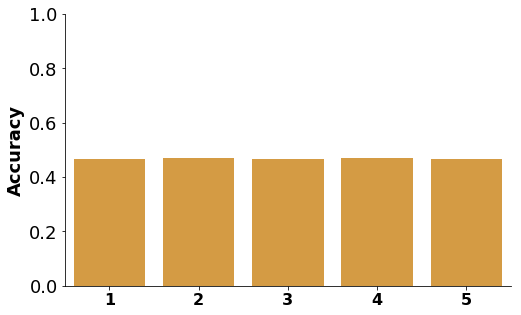

In [6]:
x = ['1','2','3','4','5']
plt.figure(figsize=(8,5))
sns.despine()
ax = sns.barplot(x=x, y=results,color='#eca02c')

# plt.title('Accuracy Score', fontsize=20, fontweight='bold')

# plt.xlabel('k-fold', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, weight='bold')

plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
plt.yticks(fontsize=18)
plt.ylim([0,1.0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('kfold_score.jpg', transparent=True)

In [0]:
files.download('kfold_score.jpg')